GEANT4 : Loading modules
GEANT4 : Loading complete.
GEANT4 : Imported all definitions.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: QGSP_BERT

Available UI session types: [ tcsh, csh ]
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
### Birks coefficients used in run time
ADDING VECTORS
CIRCLES []


/usr/local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

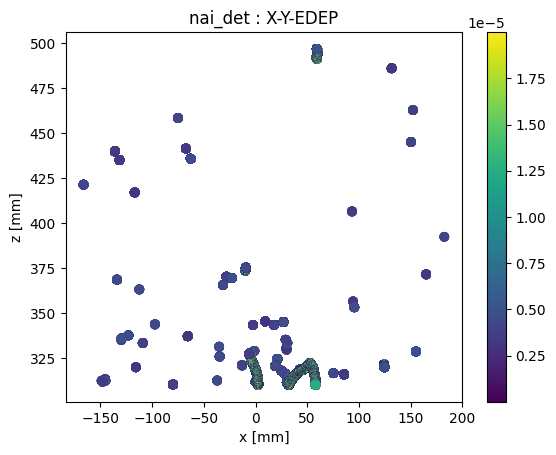

FINISHED


In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy import ns, mm, cm, m, eV, MeV, GeV, deg, twopi

import random

gRunManager = g4.G4RunManager();

class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Fixed Energy Spectrum Upward Muon Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4MuonMinus.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(0, 0, +1))
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(0.0,0.0,0.0))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        energy = 100 * MeV
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)


# In [3]: NEUTRON DETECTOR
# Make a ND array to store neutron energy

class gamma_energy_store(g4.G4VSensitiveDetector):

    def Reset(self):
        self.gamma_event = {
            "eid": [],
            "pid": [],
            "ke": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": [],
        }
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())
        if not (pdg == -22): return 0 # optical photon requirement

        # Get Before
        eid = int(gRunManager.GetCurrentEvent().GetEventID())
        pid = int(aStep.GetTrack().GetTrackID())
        pos = aStep.GetPreStepPoint().GetPosition() 
        ke = aStep.GetPreStepPoint().GetKineticEnergy() 
        edep = aStep.GetTotalEnergyDeposit()
        
        self.gamma_event["eid"].append(eid)
        self.gamma_event["pid"].append(pid)
        self.gamma_event["ke"].append(ke)
        self.gamma_event["edep"].append(edep)
        self.gamma_event["x"].append(pos.x())
        self.gamma_event["y"].append(pos.y())
        self.gamma_event["z"].append(pos.z())
        
        return 1

    def StartOfRunAction(self):
        self.Reset()

    def EndOfRunAction(self):
        self.df = pd.DataFrame(data=self.gamma_event)

    def VisualizationAction(self):
        plt.scatter(self.df.x, self.df.z, c=self.df.edep)
        plt.title(str(self.GetName()) + " : X-Y-EDEP")
        plt.xlabel("x [mm]")
        plt.ylabel("z [mm]")
        plt.colorbar()
        plt.show()
                


# In[3]: BUILD A WORLD consisting of AIR with a HDPE tube around source.
class custom_world(g4.G4VUserDetectorConstruction):   
    
    def BuildWorld(self):
        # Mother Box
        self.world = g4.build_component("world", solid="box", x=5*m, y=5*m, z=5*m, material="G4_AIR")

        g4.build_material("G4_PLASTIC_SC_VINYLTOLUENE", 
                          RINDEX_X=[0.001*eV, 20*eV],
                          RINDEX_Y=[1.4,1.4],
                          SCINTILLATIONTIMECONSTANT1=10*ns,
                          SCINTILLATIONYIELD=10000/MeV,
                          ABSLENGTH_X=[0.001*eV, 20*eV],
                          ABSLENGTH_Y=[2*m,2*m],
                          RESOLUTIONSCALE=1.0,
                          SCINTILLATIONCOMPONENT1_X=[0.001*eV, 3*eV, 4*eV, 5*eV, 20*eV],
                          SCINTILLATIONCOMPONENT1_Y=[0.,0.,1.,0.,0.]
                         )
                          
        # World Geometries
        self.sample = g4.build_component("sample", solid="tubs", rmax=20*cm, z=20*cm/2, mother=self.world, material="G4_C", pos=[0.0,0.0,+19*cm])
        self.nai_crystal = g4.build_component("nai", solid="tubs", rmax=20*cm, z=20*cm/2, mother=self.world, material="G4_PLASTIC_SC_VINYLTOLUENE", 
pos=[0.0,0.0,+41*cm])
    
    def BuildDetectors(self):
        # Sensitive Volume Definitions
        self.nai_det = gamma_energy_store("nai_det")
        self.nai_crystal.GetLogicalVolume().SetSensitiveDetector(self.nai_det)
        g4.register_detector_hooks(detector.nai_det)

    def Construct(self):
        self.BuildWorld()
        self.BuildDetectors()
        
        # Return the mother
        return self.world # top mother volume

    
# In [4]:
# Add Physics List
g4.lazy_load("*Optical*")
physics = g4.QGSP_BERT()
op = g4.G4OpticalPhysics()
physics.RegisterPhysics(op)
print(physics)
gRunManager.SetUserInitialization(physics)

# Add a World
detector = custom_world()
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = custom_generator()
gRunManager.SetUserAction(gen)

# Add standard GEANT4 Actions
g4.add_default_actions(gRunManager)

# Setup vis to check geometry (optioonal)
g4.create_visualization(gRunManager)

# Generate some events
g4.handle_beam(gRunManager, 10)

# Draw the vis plot (optional)
g4.draw_visualization(gRunManager)

print("FINISHED")

